<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/APRF_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task:
*   Use MNIST data
*   Compute APRF for multi-class categorization problem

In [7]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm # for calculate APRF

import matplotlib.pyplot as plt
import matplotlib_inline

# scalable vector graphics (svg) makes the plots crisper:
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [8]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels, then remove from data:
labels = data[:,0] # extract the 1st col as labels
data   = data[:,1:]

# normalize all data (train & test) to [0 1]:
dataNorm = data / np.max(data)

In [9]:
# Step 1: np array -> torch tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: torch tensor -> torch dataset obj (combine):
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: torch dataset obj -> torch dataloader obj:
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [10]:
def createTheMNISTNet():

  # model class:
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create a model instance:
  net = mnistNet()

  # loss function:
  lossfun = nn.CrossEntropyLoss()

  # optimizer:
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [11]:
def function2trainTheModel():

  numepochs = 10

  # create a new model:
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # loop over epochs:
  for epochi in range(numepochs):
    batchAcc  = []
    batchLoss = []

    # loop over batches:
    for X,y in train_loader:
      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

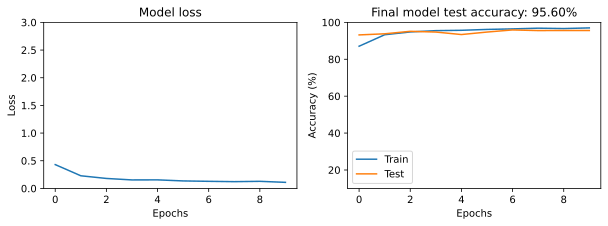

In [12]:
# build and train the model
trainAcc,testAcc,losses,net = function2trainTheModel()

# visualization starts here
fig,ax = plt.subplots(1,2,figsize=(10,3))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [20]:
# predicted digits for training data
yHat = net(train_loader.dataset.tensors[0])
print(yHat, "\n")
print(yHat[0])
print(yHat[1])
print(yHat[2], "\n")

# find index of the maximum value along row axis in the tensor `yHat`
train_predictions = torch.argmax(yHat,axis=0)
print("train_predictions:", train_predictions)

# predictions for test data
yHat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yHat,axis=1)
print("test_predictions:", test_predictions)

tensor([[ -2.4637,  -7.4083, -16.3233,  ...,  -3.1464,  -2.1405,  13.0452],
        [ -4.8774,  -2.5352,  -3.1942,  ...,  -4.8787,  -2.4939,  -4.3526],
        [-10.0124,  -2.5772,  -0.8050,  ...,   6.8612,  -8.1959,  -0.8834],
        ...,
        [-19.2173,  -6.1143,  -2.6409,  ...,  13.9707, -16.6081,  -2.7749],
        [ -3.6570,  -8.0362,  -1.8079,  ...,  -6.7151,  -1.5495,  -1.8560],
        [-54.8047,  23.6287,  -7.1603,  ...,   6.0100,   1.4980,  -9.4298]],
       grad_fn=<AddmmBackward0>) 

tensor([ -2.4637,  -7.4083, -16.3233,  -4.8158,   0.8054,  -5.1720, -21.2410,
         -3.1464,  -2.1405,  13.0452], grad_fn=<SelectBackward0>)
tensor([ -4.8774,  -2.5352,  -3.1942,   3.9676, -16.4662,   9.3500,   0.9024,
         -4.8787,  -2.4939,  -4.3526], grad_fn=<SelectBackward0>)
tensor([-10.0124,  -2.5772,  -0.8050,  -4.0363,  -4.8576,  -2.2490,  -8.6855,
          6.8612,  -8.1959,  -0.8834], grad_fn=<SelectBackward0>) 

train_predictions: tensor([9, 5, 7,  ..., 7, 5, 1])
test_pred

In [ ]:
# There are now 10 classes/indiv nums, so there are 10 precision values.

## option 1: compute precision for each number
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average=None)

## option 2: compute average precision, weighted by N
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')

## option 3: compute average precision, unweighted
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='macro')

# Confusion matrix averaged over all 10 categories/indiv nums:

In [21]:
# initialize vectors
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

# for train:
train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1],train_predictions) # accuracy is overall
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1],train_predictions,average='weighted')
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1],train_predictions,average='weighted')

# for test:
test_metrics[0] = skm.accuracy_score (test_loader.dataset.tensors[1],test_predictions)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average='weighted')
test_metrics[2] = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions,average='weighted')
test_metrics[3] = skm.f1_score       (test_loader.dataset.tensors[1],test_predictions,average='weighted')

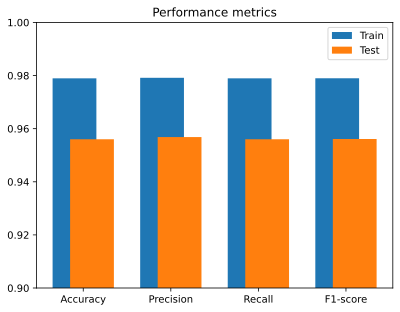

In [22]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.9,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

👆 Great! The 4 metrics (APRF) all give roughly the same values, which means the model is not biased 🎉

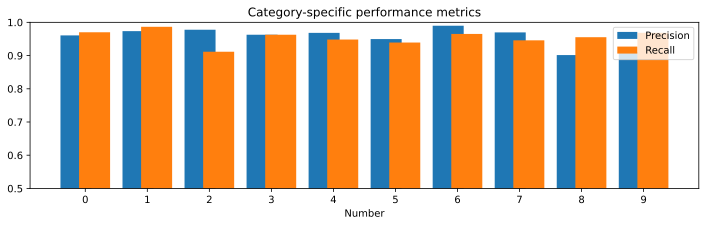

In [23]:
# calculate precision and recall for each of the 10 categories/indiv nums:

precision = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average=None)
recall    = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions,average=None)

fig = plt.figure(figsize=(12,3))
plt.bar(np.arange(10)-.15,precision,.5)
plt.bar(np.arange(10)+.15,recall,.5)
plt.xticks(range(10),range(10))
plt.ylim([.5,1])
plt.xlabel('Number')
plt.legend(['Precision','Recall'])
plt.title('Category-specific performance metrics')
plt.show()

👆 No obvious bias for each category (individual num) as well.
NOTE:
*   Precision is high (close to 1) when FP is low.
*   Recall is high (close to 1) when FN is low.

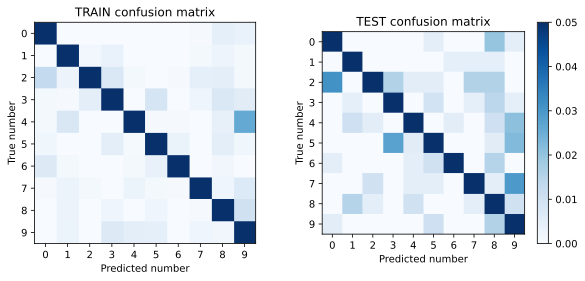

In [24]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions,normalize='true')
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions,normalize='true')

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

# confmat during TEST
a = ax[1].imshow(testConf,cmap='Blues',vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()